In [10]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
def pde(x1, x2, mu = None, conv = None):
    if mu is None and conv is None:
        mu = np.array([0, 0]).reshape((2, 1))
        conv = np.array([[1, 3/5],
                        [3/5, 2]])

    x = np.array([x1, x2])
    k = 2

    a = x - mu
    b = np.linalg.inv(conv)

    
    U = np.dot(np.transpose(a, (1, 0)), b)
    U = np.transpose(U, (1, 0))
    U = (U * a).sum(0)

    probabilities = np.power(2 * np.pi, -k/2) * np.power(np.linalg.det(conv), -1/2) * np.exp(-(1/2) * U)

    return probabilities

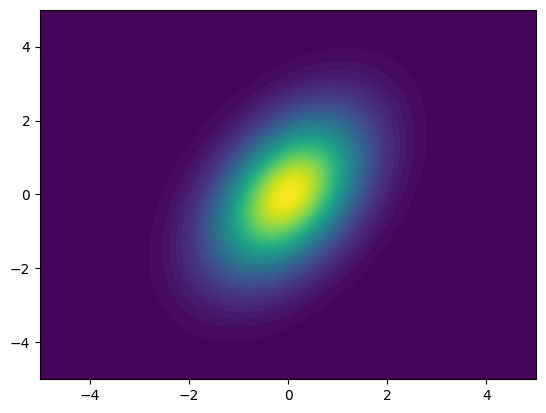

In [3]:
xmin, xmax, ymin, ymax = -5, 5, -5, 5
nx, ny = 100, 100
k = 2

x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)

xv, yv = np.meshgrid(x, y)
mu = np.array([0, 0]).reshape((2, 1, 1))
conv = np.array([[1, 3/5],
                [3/5, 2]])

x = np.array([xv, yv])

a = x - mu
b = np.linalg.inv(conv)

U = np.dot(np.transpose(np.array([a[0, ...].ravel(), a[1, ...].ravel()]), (1, 0)), b)
U = np.transpose(U, (1, 0))
U = (U * np.array([a[0, ...].ravel(), a[1, ...].ravel()])).sum(0)
U = U.reshape(nx, ny)

probabilities = np.power(2 * np.pi, -k/2) * np.power(np.linalg.det(conv), -1/2) * np.exp(-(1/2) * U)

plt.contourf(xv, yv, probabilities, levels = 50)
plt.show()

In [8]:
def rejection_sampler(pde, ax, bx, ay, by, c, n_samples):
    samples = None
    samples_left = n_samples

    while samples_left > 0:
        x = np.random.uniform(ax, bx, samples_left)
        y = np.random.uniform(ay, by, samples_left)
        z = np.random.uniform(0, c, samples_left)

        probabilities = pde(x, y)
        new_samples_indexes = np.where(probabilities > z)

        if samples is not None:
            samples = np.concatenate((samples, np.array([x[new_samples_indexes], y[new_samples_indexes]])), axis=1)
        else:
            samples = np.array([x[new_samples_indexes], y[new_samples_indexes]])
            
        samples_left -= len(new_samples_indexes[0])

    return samples

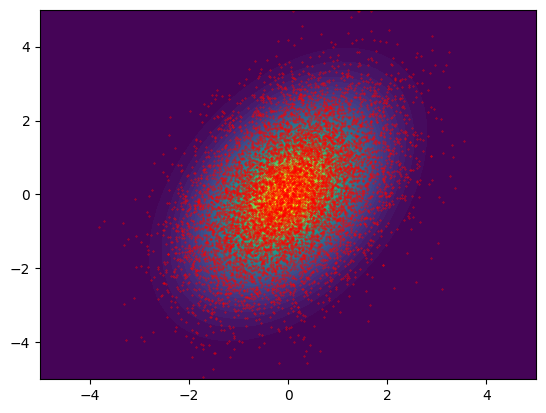

In [27]:
res = rejection_sampler(pde, xmin, xmax, ymin, ymax, 1, 10000)

plt.contourf(xv, yv, probabilities, levels = 50)

plt.scatter(res[0], res[1], s = 0.1, c = 'red')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.show()

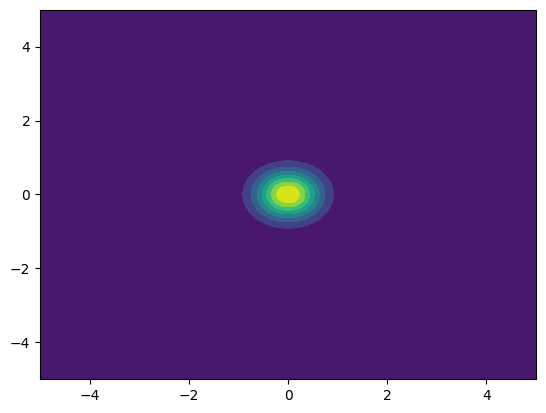

In [19]:
x, y = np.mgrid[xmin:xmax:.01, ymin:ymax:.01]
pos = np.dstack((x, y))
rv = scipy.stats.multivariate_normal([0, 0], [[0.2, 0], [0, 0.2]])
plt.contourf(x, y, rv.pdf(pos))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

In [73]:
def metropolis_hastings(pde, ax, bx, ay, by, c, n_steps, x_start = 0, y_start = 0):
    steps_left = n_steps
    samples = []
    
    q_sampler = scipy.stats.multivariate_normal([0, 0], [[0.2, 0], [0, 0.2]])

    cur_coord = np.array([0, 0])
    while steps_left > 0:
        next_coord = q_sampler.rvs() + cur_coord
        a = pde([next_coord[0]], [next_coord[1]]) / pde([cur_coord[0]], [cur_coord[1]])
        if np.random.binomial(1, min(a,1), 1)[0] == 1:
            cur_coord = next_coord
            samples.append(cur_coord)
            steps_left -= 1
    return np.array(samples)

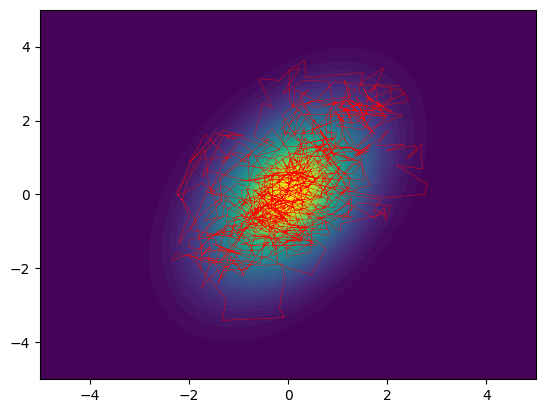

In [71]:
res = metropolis_hastings(pde, xmin, xmax, ymin, ymax, 1, 1000)

plt.plot(res[:, 0], res[:, 1], c = 'red', linewidth = 0.3)

plt.contourf(xv, yv, probabilities, levels = 50)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.show()

In [144]:
def gibson(pde, ax, bx, ay, by, c, n_steps, x_start = 0, y_start = 0):
    steps_left = n_steps
    samples = []
    
    q_sampler = scipy.stats.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]])

    cur_coord = np.array([2.0, 2.0])
    cur_index = 0
    while steps_left > 0:
        q_sample = q_sampler.rvs()
        next_coord = cur_coord.copy()
        next_coord[cur_index] += q_sample[cur_index]
        cur_index = (cur_index + 1) % k

        a = pde([next_coord[0]], [next_coord[1]]) / pde([cur_coord[0]], [cur_coord[1]])
        if np.random.binomial(1, min(a,1), 1)[0] == 1:
            cur_coord = next_coord
            samples.append(cur_coord)
            steps_left -= 1
    return np.array(samples)

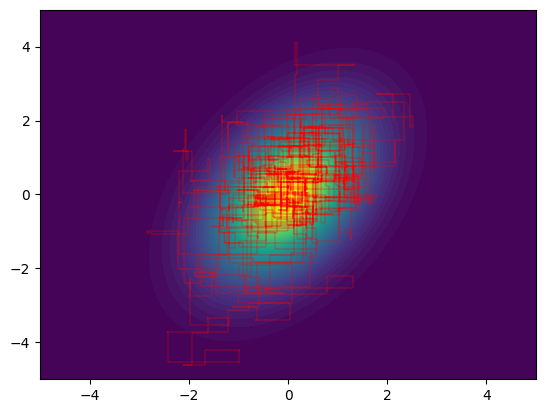

In [145]:
res = gibson(pde, xmin, xmax, ymin, ymax, 1, 1000)

plt.plot(res[:, 0], res[:, 1], c = 'red', linewidth = 0.3)

plt.contourf(xv, yv, probabilities, levels = 50)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.show()